# These scripts are for applying different regression models after integerating the data from ENTSOE and Weather APIs
# the model.pkl is produced as a final result of the scripts which is the model with best evaluation results (Random Forest)

the applied Models are:
-OLS
-Ridge
-Polynomial Regression
-Decision Trees
-Random Forest
-KNNs

Evaluation is done using:
-R-squared
-RMSE
-Residual plots

In [1]:
# importing the needed libraries
from sklearn import linear_model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, ShuffleSplit
import statsmodels.api as sm
import seaborn as sns
from math import sqrt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression,mutual_info_regression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline

In [ ]:
# Integerating both of the data from weather and electricty generation
gendf = pd.read_csv('finalCo2.csv')
gendf = gendf.groupby(['date','hour']).sum()
gendf
weather_data = pd.read_csv('weather_final.csv')
weather_data = weather_data.groupby(['date','hour']).sum()
weather_data
result = pd.concat([gendf,weather_data], axis=1)
result

In [2]:
# The file finalModel.csv has the final and integerated data of both weather and ENTSO APIs 
# the finalModel.csv has the all the first potential set of the independent variables as well as the dependent variable
model = pd.read_csv('finalModel.csv')
model = model.groupby(['date','hour']).sum()
model

Solar  Wind Offshore  Wind Onshore  weekDay  monthDay  \
date       hour                                                               
2015-01-01 0            0.0       516500.0     8128000.0      3.0       1.0   
           1            0.0       516250.0     8297500.0      3.0       1.0   
           2            0.0       514000.0     8540000.0      3.0       1.0   
           3            0.0       517750.0     8552000.0      3.0       1.0   
           4            0.0       519750.0     8643500.0      3.0       1.0   
           5            0.0       520000.0     8711750.0      3.0       1.0   
           6            0.0       521500.0     9167250.0      3.0       1.0   
           7            0.0       520250.0     9811000.0      3.0       1.0   
           8        53000.0       525250.0     9683000.0      3.0       1.0   
           9       773250.0       527000.0     9501750.0      3.0       1.0   
           10     2116750.0       525000.0    10025000.0      3.0       1.0   
           11     3364250.0       527250.0    10862500.0      3.0       1.0   
           12     4198250.0       527750.0    11575250.0      3.0       1.0   
           13     3500500.0       527750.0    11977250.0      3.0       1.0   
           14     2278750.0       524750.0    11396000.0      3.0       1.0   
           15      745500.0       524500.0    11326500.0      3.0       1.0   
           16       50000.0       524500.0    13058000.0      3.0       1.0   
           17           0.0       524500.0    14911500.0      3.0       1.0   
           18           0.0       524000.0    16344000.0      3.0       1.0   
           19           0.0       523500.0    17484500.0      3.0       1.0   
           20           0.0       522250.0    18659000.0      3.0       1.0   
           21           0.0       521000.0    19831500.0      3.0       1.0   
           22           0.0       519500.0    20716000.0      3.0       1.0   
           23           0.0       494000.0    21589000.0      3.0       1.0   
2015-01-02 0            0.0       305000.0    22166750.0      4.0       2.0   
           1            0.0       276500.0    23158000.0      4.0       2.0   
           2            0.0       282000.0    23966000.0      4.0       2.0   
           3            0.0       324750.0    24708750.0      4.0       2.0   
           4            0.0       335000.0    25386000.0      4.0       2.0   
           5            0.0       388250.0    25783750.0      4.0       2.0   
...                     ...            ...           ...      ...       ...   
2018-05-18 22           0.0       382750.0     2502750.0      4.0      18.0   
           23           0.0       343500.0     2289000.0      4.0      18.0   
2018-05-19 0            0.0       273500.0     1944750.0      5.0      19.0   
           1            0.0       243250.0     1617250.0      5.0      19.0   
           2            0.0       184000.0     1264500.0      5.0      19.0   
           3            0.0       107500.0     1053250.0      5.0      19.0   
           4            0.0        66250.0      998750.0      5.0      19.0   
           5       106250.0        71000.0     1088750.0      5.0      19.0   
           6      1466750.0        26250.0     1177000.0      5.0      19.0   
           7      4601250.0        35000.0      988000.0      5.0      19.0   
           8      9201250.0        24500.0      569750.0      5.0      19.0   
           9     13965500.0        34000.0      466250.0      5.0      19.0   
           10    17685250.0        50750.0      654250.0      5.0      19.0   
           11    19945500.0        63500.0      935500.0      5.0      19.0   
           12    21383500.0        53500.0     1058000.0      5.0      19.0   
           13    21510500.0        51500.0     1139000.0      5.0      19.0   
           14    20803500.0        12250.0     1243500.0      5.0      19.0   
           15    18928000.0        11000.0     1488000.0      5.0      1

In [21]:
# model1 has only independent variables after dropping the co2_emission
model1 = model.drop('Co2_emission' , axis=1)

In [4]:
# Dropping the not needed columns according to our feature selection criteria
model1 = model1.drop('apparentTemperature' , axis=1)
model2 = model1.drop('dewPoint' , axis=1)
model3 = model2.drop('windGust' , axis=1)
model4 = model3.drop('precipAccumulation', axis=1)
model5 = model4.drop('precipProbability' , axis=1)
model6 = model5.drop('temperature' , axis=1)
model7 = model6.drop('windBearing' , axis=1)
model8 = model7.drop('humidity' , axis=1)
model9 = model8.drop('precipIntensity' , axis=1)
model10 = model9.drop('Wind Offshore' , axis=1)
model11 = model10.drop('monthDay' , axis=1)

In [5]:
# The pearson correlation matrix
corr = model11.corr()
corr.style.background_gradient()

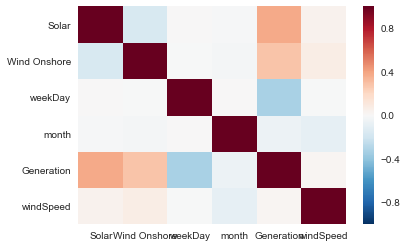

In [23]:
# Another correlation matrix better for coloring
corr = model11.corr()
ff =sns.heatmap(corr, 
           xticklabels=corr.columns.values,
           yticklabels=corr.columns.values)
fig = ff.get_figure()
fig.savefig("correlationmatrix.eps")

In [24]:
# Split into Target (y) and Data (X)
y = model['Co2_emission']
X = model11
#Split into test and training datasets randomly
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
#X_test, X_validate, y_test, y_validate = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

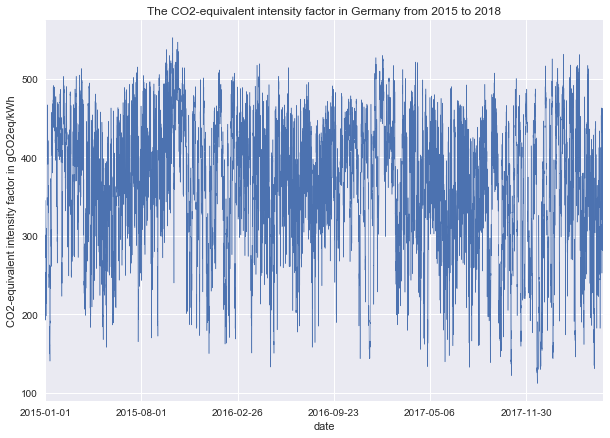

In [19]:
# The CO2 emissions in Germany from 2015 to 2018
ax = model['Co2_emission'].plot(figsize = (10,7), title = 'The CO2-equivalent intensity factor in Germany from 2015 to 2018',linewidth=0.5)
ax.set_ylabel('CO2-equivalent intensity factor in gCO2eq/kWh')
fig = ax.get_figure()
fig.savefig("outputtt.eps")

In [7]:
# The univariate feature selection and showin the score of each feature
X = X_train  
y = y_train
pd.to_numeric(y, errors='coerce')
#apply SelectKBest class to extract top 6 best features
bestfeatures = SelectKBest(score_func=f_regression, k=6)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(17,'Score'))  #print 10 best features

          Specs         Score
1  Wind Onshore  28389.316303
0         Solar   2349.295856
2       weekDay    671.135241
4    Generation    208.927508
5     windSpeed    142.416065
3         month     68.063181


In [ ]:
# Recursive Feature elimination
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR

estimator = SVR(kernel="linear")
selector = RFE(estimator, 5, step=1)
selector = selector.fit(X, y)
selector.support_ 


/Users/mogy/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


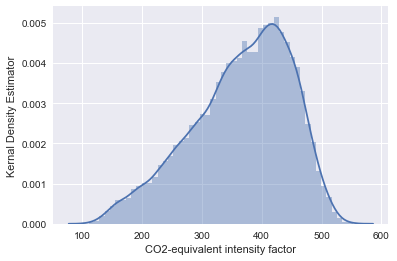

In [18]:
# Ploting KDE of the CO2 emission  in Germany
ff = sns.distplot(model['Co2_emission'])
ff.set(ylabel='Kernal Density Estimator' , xlabel='CO2-equivalent intensity factor')
fig = ff.get_figure()
fig.savefig("kde.eps")

# OLS Regrission

R-squared:
Train: 0.893949372023
Test: 0.897965300757


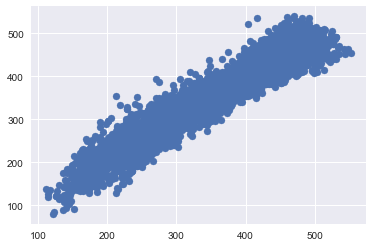

In [25]:
# Applying OLS regression to the data set and calculating the R-squared for training and testing
# plotting scatter for evaluating
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)
print('R-squared:')
print('Train:',regr.score(X_train ,y_train))
print('Test:',regr.score(X_test , y_test))
plt.scatter(y_test,y_pred)

Train:  26.991547801455198
Test:  26.475465893276485


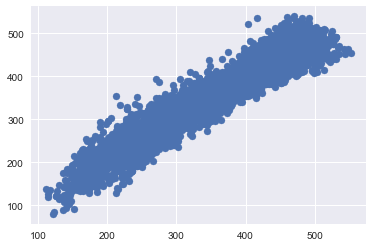

In [26]:
# computing the RMSE for the OLS on training and test datasets
ypred_train = regr.predict(X_train)
error_train = sqrt(mean_squared_error(y_train,ypred_train)) #calculate rmse
ypred_test = regr.predict(X_test)
error_test = sqrt(mean_squared_error(y_test,ypred_test)) #calculate rmse
print('Train: ',error_train)
print('Test: ',error_test)
plt.scatter(y_test,ypred_test)


# Ridge Regression

In [12]:
# applying cross-validation with 5 folds to get an idea about the mean performance of the R-squared
basic_model_ridgeR2=cross_val_score(Ridge(),X_train,y_train,cv=5)
print("Basic model - Ridge")
print("The mean of the score ", basic_model_ridgeR2.mean(),"and the 95% confidence interval of the score estimate" ,basic_model_ridgeR2.std())

Basic model - Ridge
The mean of the folds are 0.893811547437 and the standard deviation is 0.00386520201062


In [13]:
# Tunning the hyperparameters for ridge by finding the alpha and the normalization using cross-validation
parameters1= [{'alpha': [1,0.1,0.01,0.001,0.0001,0,10,100],'normalize':[True,False]}]
ridge_gsv = GridSearchCV(Ridge(), parameters1,cv=5, n_jobs=-1)
ridge_gsv.fit(X_train, y_train)
ridge_gsv.best_params_

{'alpha': 100, 'normalize': False}

In [27]:
# Training the Ridge model with the optimal hyperparameters and evaluating it with R-squared and RMSE
model_ridge = Ridge(alpha = 100, normalize = False)
model_ridge.fit(X_train, y_train)

ypred_train = model_ridge.predict(X_train)
ypred_test = model_ridge.predict(X_test)

error_train = sqrt(mean_squared_error(y_train,ypred_train)) 
error_test = sqrt(mean_squared_error(y_test,ypred_test)) 
print('R-squared:')
print('Train:', model_ridge.score(X_train, y_train))
print('Test:', model_ridge.score(X_test, y_test))
print('RMSE:')
print('Train: ',error_train)
print('Test: ',error_test)

R-squared:
Train: 0.89394936794
Test: 0.897965610945
RMSE:
Train:  26.991548321031786
Test:  26.475425650120528


# Decision Trees

In [15]:
# Tunning the hyperparameters for ridge by finding the max depth using cross-validation
basic_model_treeR2=cross_val_score(DecisionTreeRegressor(),X_train,y_train,cv=5)
print("Basic model - tree")
print("The mean of the score ", basic_model_treeR2.mean(),"and the 95% confidence interval of the score estimate" ,basic_model_treeR2.std())
parameters_tree = {'max_depth':np.arange(1,50)}

tree_gscv = GridSearchCV(DecisionTreeRegressor(), parameters_tree, cv=5, n_jobs=-1)
tree_gscv.fit(X_train, y_train)
print(tree_gscv.best_params_)

Basic model - tree
The mean score 0.875946327676 and the 95% confidence interval of the score estimate 0.00341988293176
{'max_depth': 11}


In [28]:
# Evaluating the model with R-squared and RMSE
model_tree = DecisionTreeRegressor(max_depth=11)
model_tree.fit(X_train, y_train)
ypred_train = model_tree.predict(X_train)
ypred_test = model_tree.predict(X_test)
error_train = sqrt(mean_squared_error(y_train,ypred_train)) 
error_test = sqrt(mean_squared_error(y_test,ypred_test)) 
print('R-squared:')
print('Train:', model_tree.score(X_train, y_train))
print('Test:', model_tree.score(X_test, y_test))
print('RMSE:')
print('Train: ',error_train)
print('Test: ',error_test)

R-squared:
Train: 0.949142478137
Test: 0.912986393959
RMSE:
Train:  18.691698380441935
Test:  24.449121030936922


# Polynomial Regression

In [32]:
def PolynomialRegression(degree,**kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

In [18]:
# Tunning the hyperparameters for polynomial by finding the polynomial degree using cross-validation
parameters_poly = {'polynomialfeatures__degree': np.arange(10)}
poly_gscv = GridSearchCV(PolynomialRegression(), parameters_poly, cv=5, n_jobs = -1)
poly_gscv.fit(X_train, y_train)
#print the model parameters
poly_gscv.best_params_

{'polynomialfeatures__degree': 4}

In [33]:
# Fitting and evaluating the polynomial regression 
model_poly = PolynomialRegression(degree=4, n_jobs=-1)
model_poly.fit(X_train,y_train)
ypred_poly_train = model_poly.predict(X_train)
ypred_poly_test = model_poly.predict(X_test)
error_train = sqrt(mean_squared_error(y_train,ypred_poly_train)) 
error_test = sqrt(mean_squared_error(y_test,ypred_poly_test)) 
print('R-squared:')
print('Train:', model_poly.score(X_train, y_train))
print('Test:', model_poly.score(X_test, y_test))
print('RMSE:')
print('Train: ',error_train)
print('Test: ',error_test)

R-squared:
Train: 0.915545140516
Test: 0.918903021074
RMSE:
Train:  24.087043058978065
Test:  23.603260785565734


# Random Forest

In [7]:
basic_model_rfrR2=cross_val_score(RandomForestRegressor(),X_train,y_train,cv=5)
print("Basic model - RfR")
print("The mean of the folds are", basic_model_rfrR2.mean(),"and the standard deviation is" ,basic_model_rfrR2.std())

Basic model - RfR
The mean of the folds are 0.930449129934 and the standard deviation is 0.00347760908548


In [10]:
# Tunning the hyperparameters for Random Forest by finding the max depth and number of estimators using cross-validation
parameters = {'max_depth':np.arange(1,40),
              'n_estimators':np.arange(1,100)}

rfr = RandomForestRegressor(n_jobs = -1, random_state = 42)
RF = GridSearchCV(rfr, parameters, cv=3, n_jobs=-1)
RF.fit(X_train, y_train)
RF.best_params_

{'max_depth': 23, 'n_estimators': 99}

In [34]:
# Evaluating the Random forest model using R-squared and RMSE
model_RFR = RandomForestRegressor(n_jobs=-1, max_depth=23, n_estimators=99)
model_RFR.fit(X_train, y_train)  #fit the model
ypred_train = model_RFR.predict(X_train)
ypred_test = model_RFR.predict(X_test)
error_train = sqrt(mean_squared_error(y_train,ypred_train)) 
error_test = sqrt(mean_squared_error(y_test,ypred_test)) 
print('R-squared:')
print('Train:', model_RFR.score(X_train, y_train))
print('Test:', model_RFR.score(X_test, y_test))
print('RMSE:')
print('Train: ',error_train)
print('Test: ',error_test)

R-squared:
Train: 0.991305628856
Test: 0.941103501169
RMSE:
Train:  7.728411798206734
Test:  20.11473920088178


# KNNs

In [19]:

basic_model_knnR2=cross_val_score(KNeighborsRegressor(),X_train,y_train,cv=5)
print("Basic model - KNN")
print("The mean of the folds are", basic_model_knnR2.mean(),"and the standard deviation is" ,basic_model_knnR2.std())

Basic model - KNN
The mean of the folds are 0.91169576678 and the standard deviation is 0.00393702994241


In [21]:
# Tunning the hyperparameters for KNNs by finding the number of neighbors and the weighing way using cross-validation
params = {'n_neighbors': np.arange(1,15),
         'weights': ['distance', 'uniform']}

model_knn = GridSearchCV(KNeighborsRegressor(), params, cv=5, n_jobs=-1)
model_knn.fit(X_train, y_train)

model_knn.best_params_

{'n_neighbors': 14, 'weights': 'uniform'}

In [35]:
# Evaluation with R-squared and RMSE
model_knn = KNeighborsRegressor(n_neighbors = 14, weights = 'uniform', n_jobs=-1)
model_knn.fit(X_train, y_train)  #fit the model
ypred_train = model_knn.predict(X_train)
ypred_test = model_knn.predict(X_test)
error_train = sqrt(mean_squared_error(y_train,ypred_train)) 
error_test = sqrt(mean_squared_error(y_test,ypred_test)) 
print('R-squared:')
print('Train:', model_knn.score(X_train, y_train))
print('Test:', model_knn.score(X_test, y_test))
print('RMSE:')
print('Train: ',error_train)
print('Test: ',error_test)


R-squared:
Train: 0.930675219269
Test: 0.923770246188
RMSE:
Train:  21.823048581224178
Test:  22.88399928115909


In [23]:
# pickling the Random Forest model to be used in the architecture
from sklearn.externals import joblib
joblib.dump(model_RFR, 'model.pkl')

['model.pkl']

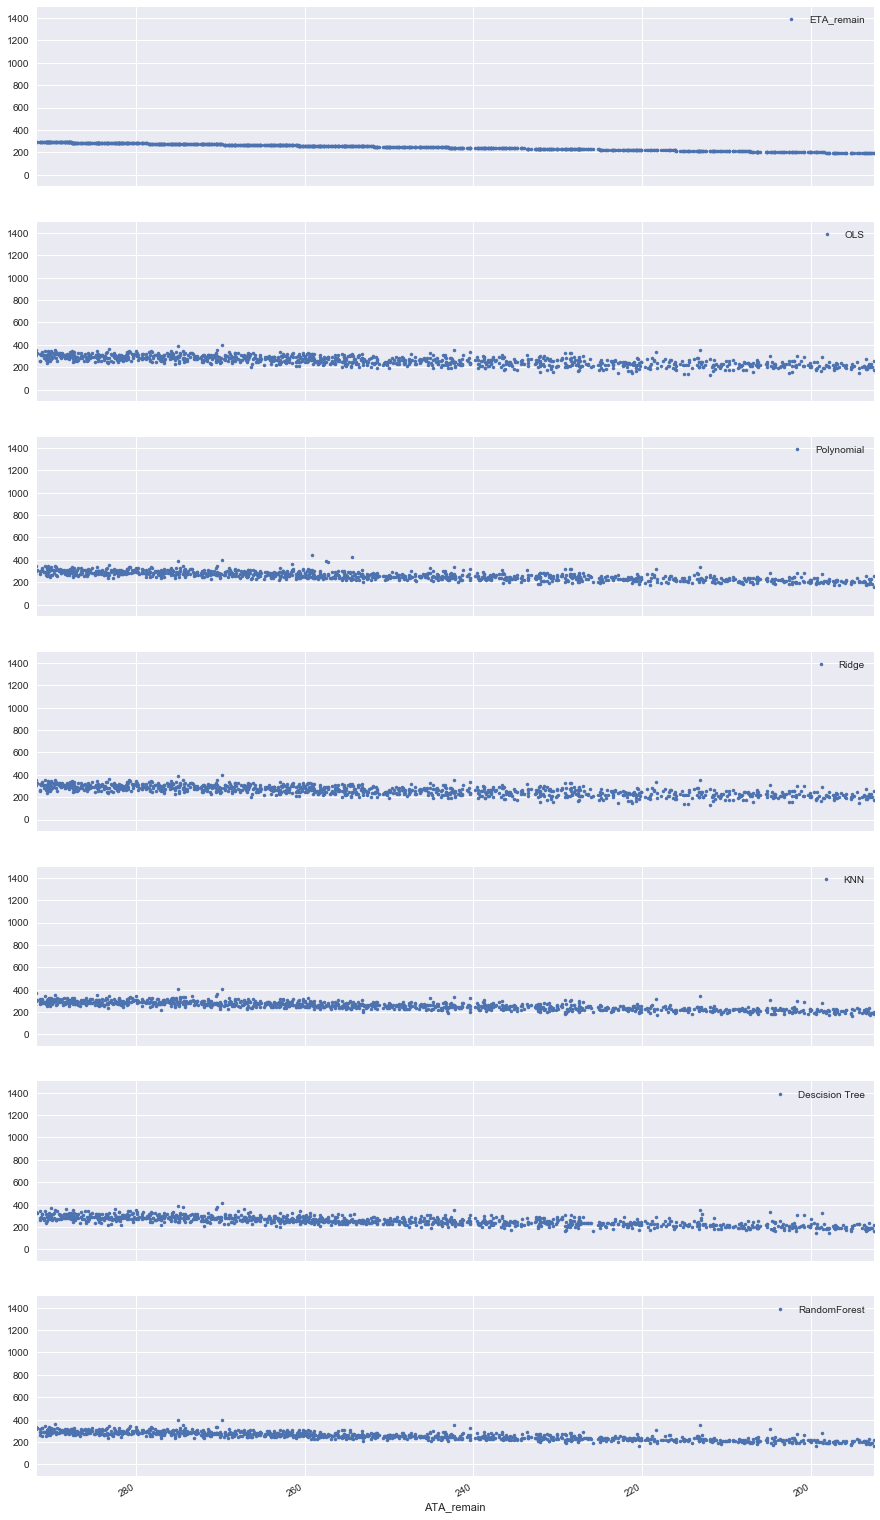

In [36]:
# Residual plots
def PolynomialRegression(degree,**kwargs):
    return make_pipeline(PolynomialFeatures(degree=degree), LinearRegression(**kwargs))
#Statsmodel 
model_ols = linear_model.LinearRegression()
model_ols.fit(X_train, y_train)
#Polynomial Model
model_poly = PolynomialRegression(degree=4, n_jobs=-1)
model_poly.fit(X_train,y_train)
#Ridge Regression  
model_Ridge = Ridge(alpha = 100, normalize = False)
model_Ridge.fit(X_train, y_train)
#Descition Tree Regression Model
model_tree = DecisionTreeRegressor(max_depth=11)
model_tree.fit(X_train, y_train)
#KNN-Regression Model
model_knn = KNeighborsRegressor(n_neighbors = 14, weights = 'uniform', n_jobs=-1)
model_knn.fit(X_train, y_train)
#Random Forest Model  
model_RFR = RandomForestRegressor(n_jobs=-1, max_depth=23, n_estimators=99)
model_RFR.fit(X_train, y_train)



result = pd.DataFrame(columns=['ATA_remain','ETA_remain','OLS',
                               'Polynomial','Ridge','KNN','Descision Tree',
                               'RandomForest'])

result['ATA_remain'] = y_test
result['ETA_remain'] = y_test
result['KNN'] = model_knn.predict(X_test)
result['Polynomial'] = model_poly.predict(X_test)
result['OLS'] = model_ols.predict(X_test)
result['Ridge'] = model_Ridge.predict(X_test)
result['RandomForest'] = model_RFR.predict(X_test)
result['Descision Tree'] = model_tree.predict(X_test)

result_plot =  result.plot(x='ATA_remain', marker='.', subplots=True, style='o', figsize=[15,30])
for i in range(7):
    result_plot[i].set_ylim([-100, 1500])
    

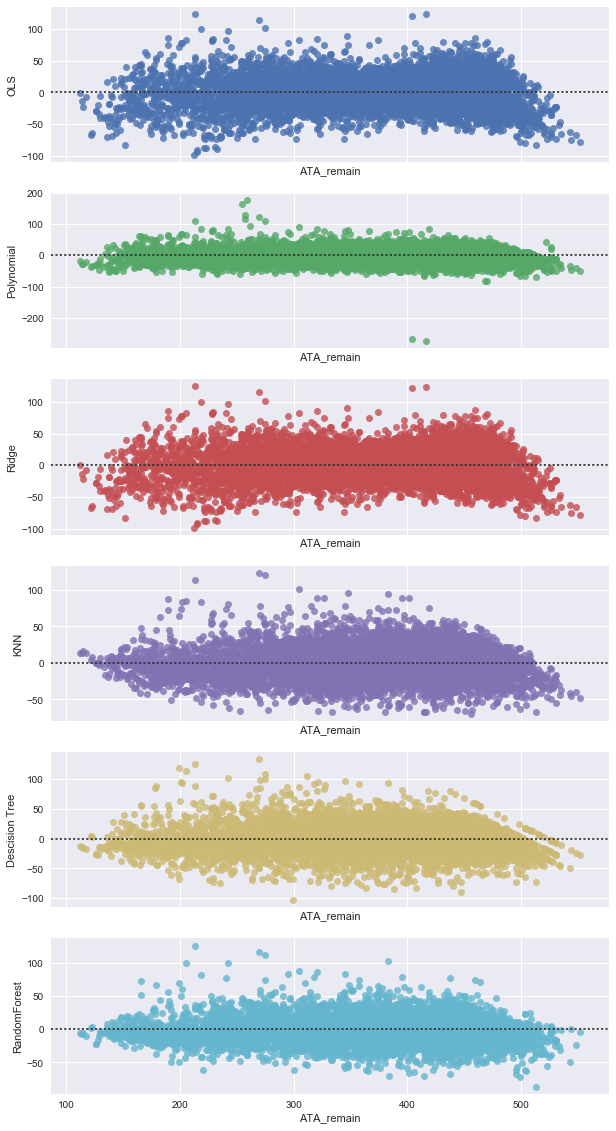

In [37]:
# Residual plots
f, axarr = plt.subplots(6, sharex=True, figsize=[10,20])
f1=sns.residplot(result['ATA_remain'],result['OLS'],ax=axarr[0])
f2=sns.residplot(result['ATA_remain'],result['Polynomial'],ax=axarr[1])
f3=sns.residplot(result['ATA_remain'],result['Ridge'],ax=axarr[2])
f4=sns.residplot(result['ATA_remain'],result['KNN'],ax=axarr[3])
f5=sns.residplot(result['ATA_remain'],result['Descision Tree'],ax=axarr[4])
f6=sns.residplot(result['ATA_remain'],result['RandomForest'],ax=axarr[5])
for i in range(7):
    result_plot[i].set_ylim([-1500, 1500])


In [38]:
# exporting the residual plots as image
f1= f1.get_figure()
f1.savefig("residplot.eps")